# Setup

In [498]:
%%capture --no-stderr
%pip install --quiet -U langgraph pydantic

25535.21s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [499]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [500]:
_set_env("LANGCHAIN_API_KEY")
_set_env("LANGCHAIN_TRACING_V2")
_set_env("LANGCHAIN_PROJECT")

# Write Section Graph

## State

In [501]:
from typing import Annotated, Literal, Optional

from langchain_core.documents import Document

# from langgraph.graph.message import add
from agents.blog.schema import Section


# @dataclass(kw_only=True)
# class WriteBlogSectionState:
#     """State structure for the agent."""

#     tavily_topic: Annotated[Literal["general", "news"], lambda x, y: y] = field(
#         default="general",
#         metadata={"description": "Type of search to perform ('news' or 'general')"},
#     )
#     # tavily_days: Optional[int] # Only applicable for news topic
#     number_of_queries: Annotated[int, lambda x, y: y] = field(
#         default=5,
#         metadata={"description": "Number web search queries to perform per section"},
#     )
#     section: Annotated[Section, lambda x, y: y] = field(
#         metadata={"description": "Section of the blog post to write."},
#     )
#     completed_sections: Optional[list[Section]] = field(
#         default=None,
#         metadata={"description": "Sections that have been completed."},
#     )
#     reference_content: Annotated[list[Document], reduce_docs] = field(
#         metadata={
#             "description": "Collection of documents to reference when writing the blog."
#         },
#     )
#     word_limit: Annotated[int, lambda x, y: y] = field(
#         default=500,
#         metadata={"description": "Word limit for the section being written."},
#     )
#     search_limit: Annotated[int, lambda x, y: y] = field(
#         default=3,
#         metadata={
#             "description": "Limit on number of searches to perform when writing content."
#         },
#     )
#     completed_blog_sections: Annotated[str, lambda x, y: y] = field(
#         default="",
#         metadata={
#             "description": "String of any completed sections from research to write final sections"
#         },
#     )

In [502]:
# @dataclass(kw_only=True)
# class WriteBlogSectionOutput:
#     """Output structure for the agent."""

#     completed_sections: Optional[list[Section]] = field(
#         default=None,
#         metadata={"description": "Sections that have been completed."},
#     )


In [503]:
# class SectionState(TypedDict):
#     tavily_topic: Literal["general", "news"] # Tavily search topic
#     tavily_days: Optional[int] # Only applicable for news topic
#     number_of_queries: int # Number web search queries to perform per section
#     section: Section # Report section
#     source_str: str # String of formatted source content from web search
#     report_sections_from_research: str # String of any completed sections from research to write final sections
#     completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

# class SectionOutputState(TypedDict):
#     completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

In [504]:
from operator import add

from pydantic import BaseModel


class BlogWriteSectionState(BaseModel):
    """State structure for the agent."""

    tavily_topic: Literal["general", "news"] = "general"
    tavily_days: Optional[int] = None
    number_of_queries: int = 5
    section: Section
    completed_sections: Annotated[list[Section], add] = []
    reference_content: list[Document] = []
    word_limit: int = 500
    search_limit: int = 3
    completed_blog_sections: str = ""


class BlogWriteSectionOutput(BaseModel):
    """Output structure for the agent."""

    completed_sections: Annotated[list[Section], add] = None

## Nodes

In [505]:
async def write_section(state: BlogWriteSectionState) -> BlogWriteSectionOutput:
    """Simulate writing section."""
    # Get state
    # section = state["section"]
    section = state.section
    # Generate section
    section_content = f"Content for {section.name} section."

    # Write content to the section object
    section.content = section_content

    # return WriteBlogSectionOutput(completed_sections=[state.section])
    # return {"completed_sections": [state["section"]]}
    return {"completed_sections": [state.section]}

## Graph

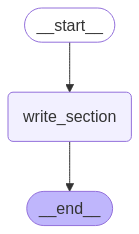

In [506]:
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph

# Define the graph
# section_builder = StateGraph(state_schema=WriteBlogSectionState)
# section_builder = StateGraph(state_schema=SectionState, output=SectionOutputState)
section_builder = StateGraph(
    state_schema=BlogWriteSectionState, output=BlogWriteSectionOutput
)
section_builder.add_node(write_section)

section_builder.add_edge(START, "write_section")
section_builder.add_edge("write_section", END)

# Compile
writer_graph = section_builder.compile()
writer_graph.name = "Blog Graph"

# View
display(Image(writer_graph.get_graph(xray=1).draw_mermaid_png()))

In [507]:
# create dummy section
section = Section(
    name="Background",
    description="Background on the topic",
    content="",
    research=True,
)
# state = WriteBlogSectionState(section=section, reference_content=[])  # create state
# state = {
#     "tavily_topic": "general",
#     "tavily_days": None,
#     "number_of_queries": 5,
#     "section": section,
#     "source_str": "",
#     "report_sections_from_research": "",
#     "completed_sections": [],
# }
state = BlogWriteSectionState(section=section, reference_content=[])  # create state
result = await writer_graph.ainvoke(state)  # excercise the graph

In [508]:
result

{'completed_sections': [Section(name='Background', description='Background on the topic', research=True, content='Content for Background section.')]}

# Blog Graph

## State

In [509]:
from typing import Annotated, Optional

from langchain_core.documents import Document
from langchain_core.messages import AnyMessage

from agents.blog.schema import BlogRequest, Section


# @dataclass(kw_only=True)
# class BlogState:
#     """State structure for the agent."""

#     messages: Annotated[list[AnyMessage], add_messages] = field(
#         default_factory=list,
#         metadata={"description": "History of chat messages."},
#     )
#     blog_request: Optional[BlogRequest] = field(
#         default=None,
#         metadata={"description": "User inputs describing desired blog."},
#     )
#     reference_content: Annotated[list[Document], reduce_docs] = field(
#         default_factory=list,
#         metadata={
#             "description": "Collection of documents to reference when writing the blog."
#         },
#     )
#     sections: list[Section] = field(
#         default_factory=list,
#         metadata={"description": "Sections of the blog post."},
#     )
#     completed_sections: Annotated[list, operator.add] = field(
#         default_factory=list,
#         metadata={"description": "Sections that have been completed."},
#     )
#     blog_structure: str = field(
#         default="",
#         metadata={"description": "The structure of the blog post."},
#     )
#     final_blog: str = field(
#         default="",
#         metadata={"description": "The final blog post."},
#     )
#     completed_blog_sections: str = field(
#         default="",
#         metadata={"description": "Formatted string of various sections completed."},
#     )

In [510]:
# class ReportState(TypedDict):
#     topic: str # Report topic
#     tavily_topic: Literal["general", "news"] # Tavily search topic
#     tavily_days: Optional[int] # Only applicable for news topic
#     report_structure: str # Report structure
#     number_of_queries: int # Number web search queries to perform per section
#     sections: list[Section] # List of report sections
#     completed_sections: Annotated[list, operator.add] # Send() API key
#     report_sections_from_research: str # String of any completed sections from research to write final sections
#     final_report: str # Final report

In [511]:
from operator import add

from pydantic import BaseModel


class BlogState(BaseModel):
    """State structure for the agent."""

    messages: list[AnyMessage] = []
    blog_request: Optional[BlogRequest]
    reference_content: list[Document] = []
    sections: list[Section] = []
    completed_sections: Annotated[list, add] = []
    blog_structure: str = ""
    final_blog: str = ""
    completed_blog_sections: str = ""

## Nodes

In [512]:
# def define_structure(state: BlogState) -> BlogState:
def define_structure(state: BlogState) -> BlogState:
    """Define structure for the blog post."""
    # Generate sections (statically)
    sections = [
        Section(
            name="Introduction",
            description="Introduction to the topic",
            content="",
            research=False,
        ),
        Section(
            name="Background",
            description="Background on the topic",
            content="",
            research=True,
        ),
        Section(
            name="Methodology",
            description="Methodology for the research",
            content="",
            research=True,
        ),
        Section(
            name="Results",
            description="Results of the research",
            content="",
            research=True,
        ),
        Section(
            name="Discussion",
            description="Discussion of the results",
            content="",
            research=True,
        ),
        Section(
            name="Conclusion",
            description="Conclusion of the research",
            content="",
            research=False,
        ),
    ]
    return {"sections": sections}

In [513]:
# def approve_structure(state: BlogState) -> BlogState:
def approve_structure(state: BlogState) -> BlogState:
    """Simulate HITL approval of the blog post structure."""
    return {"sections": state.sections}
    # return {"sections": []}

In [514]:
from langgraph.constants import Send


def spawn_section_writing(state: BlogState):
    # def spawn_section_writing(state: ReportState):
    """This is the "map" step when we kick off web research for some sections of the report"""
    # Kick off section writing in parallel via Send() API for any sections that require research
    return [
        # Send("write_section", WriteBlogSectionState(section=s, reference_content=state.reference_content))
        Send(
            "write_section",
            {
                "tavily_topic": "general",
                "tavily_days": None,
                "number_of_queries": 5,
                "section": s,
                "source_str": "",
                "report_sections_from_research": "",
                "completed_sections": [],
            },
        )
        for s in state.sections
        # for s in state["sections"]
        if s.research
    ]

In [515]:
def format_sections(sections: list[Section]) -> str:
    """Format a list of sections into a string"""
    formatted_str = ""
    for idx, section in enumerate(sections, 1):
        formatted_str += f"""
{"=" * 60}
Section {idx}: {section.name}
{"=" * 60}
Description:
{section.description}
Requires Research: 
{section.research}

Content:
{section.content if section.content else "[Not yet written]"}

"""
    return formatted_str


def gather_completed_sections(state: BlogState):
    # def gather_completed_sections(state: ReportState):
    """Gather completed sections from research"""
    # List of completed sections
    completed_sections = state.completed_sections
    # completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_blog_sections = format_sections(completed_sections)

    return {"completed_blog_sections": completed_blog_sections}

In [516]:
# def write_final_sections(state: WriteBlogSectionState):
# def write_final_sections(state: SectionState):
def write_final_sections(state: BlogWriteSectionState):
    """Write final sections of the report, which do not require web search and use the completed sections as context"""
    # Get state
    section = state.section
    # section = state["section"]

    # Generate section
    section_content = f"Final section {section.name}"

    # Write content to section
    section.content = section_content

    # Write the updated section to completed sections
    return {"completed_sections": [section]}

In [517]:
# def spawn_final_section_writing(state: ReportState):
def spawn_final_section_writing(state: BlogState):
    """This is the "map" step when we kick off research on any sections that require it using the Send API"""
    # Kick off section writing in parallel via Send() API for any sections that do not require research
    return [
        # Send("write_final_sections", {
        #     "tavily_topic": "general",
        #     "tavily_days": None,
        #     "number_of_queries": 5,
        #     "section": s,
        #     "source_str": "",
        #     "report_sections_from_research": "",
        #     "completed_sections": [],
        # })
        Send(
            "write_final_sections",
            BlogWriteSectionState(
                section=s, completed_blog_sections=state.completed_blog_sections
            ),
        )
        # for s in state["sections"]
        for s in state.sections
        if not s.research
    ]

In [518]:
# def compile_final_report(state: ReportState):
def compile_final_report(state: BlogState):
    """Compile the final report"""
    # Get sections
    # sections = state["sections"]
    sections = state.sections
    # completed_sections = {s.name: s.content for s in state["completed_sections"]}
    completed_sections = {s.name: s.content for s in state.completed_sections}

    # Update sections with completed content while maintaining original order
    for section in sections:
        section.content = completed_sections[section.name]

    # Compile final report
    all_sections = "\n\n".join([s.content for s in sections])

    return {"final_blog": all_sections}

## Graph

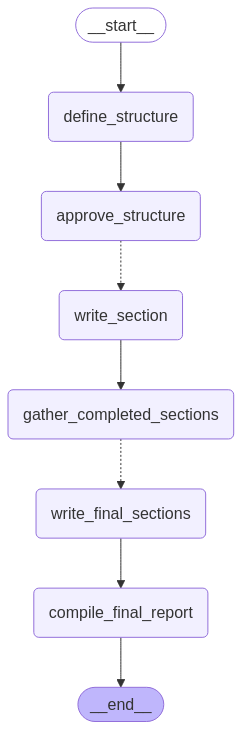

In [519]:
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph

# Define the graph
builder = StateGraph(state_schema=BlogState)
# builder = StateGraph(state_schema=ReportState)
builder.add_node(define_structure)
builder.add_node(approve_structure)
builder.add_node("write_section", writer_graph)
builder.add_node(gather_completed_sections)
builder.add_node(write_final_sections)
builder.add_node(compile_final_report)

builder.add_edge(START, "define_structure")
builder.add_edge("define_structure", "approve_structure")
# # Use conditional edge to send documents to summarization
builder.add_conditional_edges(
    "approve_structure", spawn_section_writing, ["write_section"]
)
builder.add_edge("write_section", "gather_completed_sections")
builder.add_conditional_edges(
    "gather_completed_sections", spawn_final_section_writing, ["write_final_sections"]
)
builder.add_edge("write_final_sections", "compile_final_report")
builder.add_edge("compile_final_report", END)

# Compile
graph = builder.compile()
graph.name = "Blog Graph"

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

# Test

In [520]:
state = BlogState(sections=[], blog_request=None)  # create state
# state = {
#     "tavily_topic": "general",
#     "tavily_days": None,
#     "number_of_queries": 5,
#     "sections": [],
#     "source_str": "",
#     "report_sections_from_research": "",
#     "completed_sections": [],
# }
result = await graph.ainvoke(input=state)  # excercise the graph

In [521]:
# Markdown(result.get('final_report', ""))
# Markdown(result.)
result

{'messages': [],
 'blog_request': None,
 'reference_content': [],
 'sections': [Section(name='Introduction', description='Introduction to the topic', research=False, content='Final section Introduction'),
  Section(name='Background', description='Background on the topic', research=True, content='Content for Background section.'),
  Section(name='Methodology', description='Methodology for the research', research=True, content='Content for Methodology section.'),
  Section(name='Results', description='Results of the research', research=True, content='Content for Results section.'),
  Section(name='Discussion', description='Discussion of the results', research=True, content='Content for Discussion section.'),
  Section(name='Conclusion', description='Conclusion of the research', research=False, content='Final section Conclusion')],
 'completed_sections': [Section(name='Background', description='Background on the topic', research=True, content='Content for Background section.'),
  Section(